In [1]:
import numpy as np
import configparser as cp
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from scipy.spatial import distance
import scipy.stats
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import random
import keras_utils as ku
from plot_utils import *
from ipyfilechooser import FileChooser

In [2]:
path = "/home/vanessalama09/cs526/configs/"
path16 = "/home/vanessalama09/cs526/configs/16_1n0u-1novc/20_1n0u-1n0vc.ini"
path15 = "/home/vanessalama09/cs526/configs/15_1n0u-1novc/20_1n0u-1n0vc.ini"
path14 = "/home/vanessalama09/cs526/configs/14_1n0u-1novc/20_1n0u-1n0vc.ini"

In [3]:
metric_functions = {
    'Maximum': (lambda err: np.max(err, axis=1)),
    'Median': (lambda err: np.median(err, axis=1)),
    'Root Mean Squared': (lambda err: np.sqrt(np.mean(np.square(err), axis=1))),
    'Mean': (lambda err: np.mean(err, axis=1))
}

def generate_statistics(dataset_files, metrics):
    values = {name:[] for name in metrics}
    for dataset in dataset_files:
        config_errors = np.loadtxt(dataset)
        for m in metrics:
            values[m].append(metric_functions[m](config_errors))
    return values

In [4]:
def resolution_seperate_directories(path_to_configs):
    list_of_directories = os.scandir(path_to_configs)
    directories_in_string = []
    for folder in list_of_directories:
        directories_in_string.append(folder.name)
    for folder_names in directories_in_string:
        if folder_names.startswith('16'):
            highres_directory = path_to_configs + folder_names + "/"
        elif folder_names.startswith('15'):
            midres_directory = path_to_configs + folder_names + "/"
        elif folder_names.startswith('14'):
            lowres_directory = path_to_configs + folder_names + "/"
    return highres_directory, midres_directory, lowres_directory

In [5]:
def latent_space_loss(configs_path, latentspace_range):
    path_to_project = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    
    configs_names = [configs_path + "5_1n0u-1n0vc.ini", configs_path + "10_1n0u-1n0vc.ini",
                configs_path + "15_1n0u-1n0vc.ini", configs_path + "20_1n0u-1n0vc.ini",
                configs_path + "25_1n0u-1n0vc.ini", configs_path + "30_1n0u-1n0vc.ini",
                configs_path + "35_1n0u-1n0vc.ini", configs_path + "40_1n0u-1n0vc.ini",
                configs_path + "45_1n0u-1n0vc.ini", configs_path + "50_1n0u-1n0vc.ini"]

    configs = []
    for i in configs_names:
        conf = cp.ConfigParser()
        conf_= i
        conf.read(conf_)
        configs.append(conf)
    
    error = []    
    for i in configs:
        history = ku.loadHist(path_to_project + "/" + i['output']['historyFile'])
        error.append(history['loss'][-1])

    return error

In [6]:
def latentspace_plot(configs_path):
    latentspace_size = range(5,55,5)
    high, mid, low = resolution_seperate_directories(configs_path)
    error_16 = latent_space_loss(high, latentspace_size)
    error_15 = latent_space_loss(mid, latentspace_size)
    error_14 = latent_space_loss(low, latentspace_size)
    
    plt.plot(latentspace_size, error_16, 'o-', label = '1e16')
    plt.plot(latentspace_size, error_15, 'o-', label = '1e15')
    plt.plot(latentspace_size, error_14, 'o-', label = '1e14')
    plt.xlabel('Latent Space Dimension')
    plt.ylabel('Mean Squared Error')
    #plt.ylim(0,0.00060)
    plt.title('Image Reconstruction Error')
    plt.legend()
    

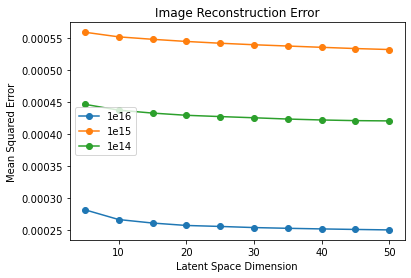

In [7]:
latentspace_plot(path)

In [8]:
def plot_knn_error(stats, comparison, intensity, ylim_top, path_to_figures):
    path_to_project = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    x = [x for x in range(2, 21)]
    if comparison:
        plt.figure(figsize=(6, 5))
    else:
        plt.figure(figsize=(6,6))
    for (color, metric) in (('C0', 'Root Mean Squared'),
                            #('C1', 'Mean'),
                            ('C1', 'Median'),
                            #('C2', 'Maximum')
                            ):
        label = metric
        data = stats[metric]
        
        plt.boxplot(data, whis=[5, 95], sym='', positions=x,
                boxprops={'color':color}, whiskerprops={'color':color}, capprops={'color':color}, medianprops={'color':color})
        median = np.median(data, axis=1)
        plt.plot(x, median, color+'o-', label=label)
        #print(np.argmin(median))
        plt.axvline(x=x[np.argmin(median)], color=color, zorder=1, ls=':', label='_nolegend_')

    plt.ylabel("Error (Degrees)", fontsize=14)
    plt.xlabel("K", fontsize=14)
    plt.ylim(0, ylim_top)

    plt.legend()
    if comparison:
        plt.title('Error for K-Nearest Neighbors - '+intensity+' - '+protein, fontsize=14)
    else:
        plt.title('Error for K-Nearest Neighbors - '+intensity, fontsize=14)

    os.makedirs(path_to_figures+'visual/', exist_ok=True)
    plt.savefig(path_to_figures+'visual/KNN error vs K_box-error'+('-compare' if comparison else '')+'.png',
                dpi=300, transparent='True', bbox_inches='tight', pad_inches=0.05)

In [9]:
def knn_error_stats(latent_space, configs_path):
    path_to_project = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    conf = cp.ConfigParser()
    conf.read(configs_path+str(latent_space)+'_1n0u-1n0vc.ini')
    path_to_errors = conf['output']['errorPath']
    path_to_save_figures = path_to_project + '/' + path_to_errors
    x = [x for x in range(2, 21)]
    error_stats = generate_statistics((path_to_project + '/' + path_to_errors + str(k) + ' Nearest_Neighbors/rf_test_errors.txt'
                                                for k in x), 
                                               ['Root Mean Squared', 'Median'])
    return error_stats, path_to_save_figures

In [10]:
def knn_k_selection(configs_path, latentspace_size):
    high, mid, low = resolution_seperate_directories(configs_path)
    error_stat_high, path_to_figs = knn_error_stats(latentspace_size, high)
    error_stat_mid, _ = knn_error_stats(latentspace_size, mid)
    error_stat_low, _ = knn_error_stats(latentspace_size, low)
    plot_knn_error(error_stat_high, 0, 'High', 70, path_to_figs)
    plot_knn_error(error_stat_mid, 0, 'Medium', 70, path_to_figs)
    plot_knn_error(error_stat_low, 0, 'Low', 70, path_to_figs)

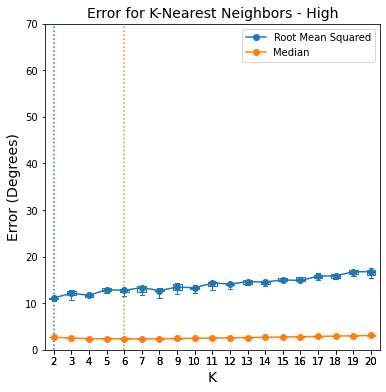

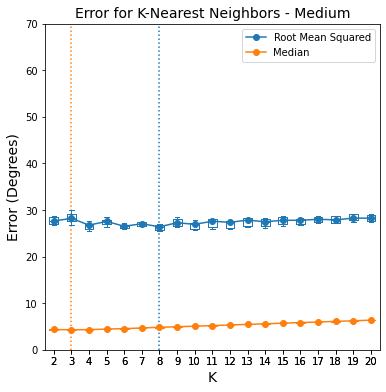

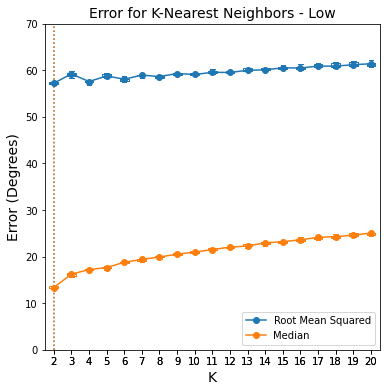

In [11]:
knn_k_selection(path, 20)

In [12]:
def read_files(configs_path, latent_space, n_neighbors):
    path_to_project = os.path.normpath(os.getcwd() + os.sep + os.pardir)
    conf = cp.ConfigParser()
    conformation_1 = configs_path+str(latent_space)+'_1n0u-1n0vc.ini'
    conf.read(conformation_1)
    error_path = conf['output']['errorPath']
    test_error = np.loadtxt(path_to_project+'/'+error_path+str(n_neighbors)+" Nearest_Neighbors/rf_test_errors.txt")
    testing_errors = np.transpose(np.array(test_error))
    psi_test_error = np.loadtxt(path_to_project+'/'+error_path+str(n_neighbors)+" Nearest_Neighbors/psi_test_errors.txt")
    psi_testing_errors = np.transpose(np.array(psi_test_error))
    test_accuracies = np.loadtxt(path_to_project+'/'+error_path+str(n_neighbors)+" Nearest_Neighbors/rf_test_accuracies_conf.txt")
    return testing_errors[:,0], psi_testing_errors[:,0],test_accuracies

In [13]:
def box_plots(errors, y_min, y_max, step, name, y_label, title, xticks_labels):
    fig, ax = plt.subplots()
    ax.boxplot(errors, whis=[0, 95], sym='.', showfliers=False)
    ax.set_yticks(np.arange(y_min, y_max+1, step))
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.set_xlabel("Resolution")
    ax.set_ylabel(y_label)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off
    ax.set_xticklabels(xticks_labels)
    #fig.savefig("Figures/JLESC/" + name + ".png", dpi=300, transparent='True',
                        #bbox_inches='tight', pad_inches=0.05)

In [14]:
def plot_comparison_plots(configs_path, latent_space, n_neighbors_high, n_neighbors_mid, n_neighbors_low):
    high, mid, low = resolution_seperate_directories(configs_path)
    errors_accuracies_high = read_files(high, latent_space, n_neighbors_high)
    errors_accuracies_mid = read_files(mid, latent_space, n_neighbors_mid)
    errors_accuracies_low = read_files(low, latent_space, n_neighbors_low)
    box_plots([errors_accuracies_high[0], errors_accuracies_mid[0], errors_accuracies_low[0]], 0, 180, 10, 'Error_degree_ef2', 'Error Degree', 'Error Degree for EF2', ['High', 'Medium', 'Low'])
    box_plots ([errors_accuracies_high[1], errors_accuracies_mid[1], errors_accuracies_low[1]], 0, 120, 10, 'Psi_differece_ef2', 'Psi Difference', 'Psi Difference for EF2', ['High', 'Medium', 'Low'])
    box_plots ([errors_accuracies_high[2], errors_accuracies_mid[2], errors_accuracies_low[2]], 0, 1.1, 0.1, 'Conformation_accuracy_ef2', 'Conformation Accuracy', 'Conformation Accuracy for EF2', ['High', 'Medium', 'Low'])

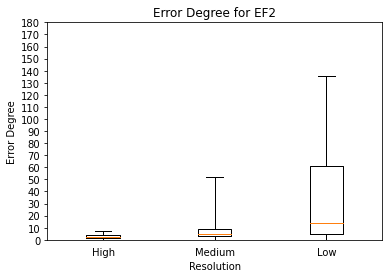

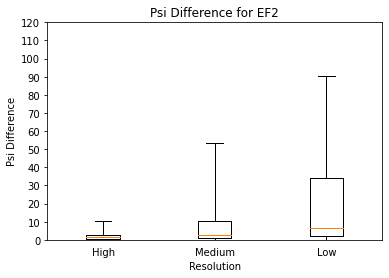

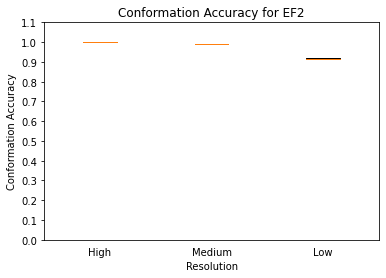

In [15]:
plot_comparison_plots(path, 20, 2, 8, 2)